<a href="https://colab.research.google.com/github/JoelPerezD/Libretas-clase/blob/main/Copy_of_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



# Curso *Ingeniería de Características*

### Usando la API para obtener datos sobre personas desaparecidas del RNPDNO


<p> Julio Waissman Vilanova </p>



<a target="_blank" href="https://colab.research.google.com/github/mcd-unison/ing-caract/blob/main/ejemplos/integracion/python/RNPDNO-API.ipynb"><img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Ejecuta en Google Colab</a>

</center>

In [4]:
import os
import sys
import requests
import datetime

import pandas as pd
import json


## Calentando motores

Para descargar los datos, vamos a consultar directamente la base de datos pública del [Registro Nacional de Personas Desaparecidas y No Localizadas (RNPDNO)](https://versionpublicarnpdno.segob.gob.mx/Dashboard/Index).

El RNPDNO no tiene una API tal cual, sin embargo, [Pablo Reyes Moctezuma](https://github.com/pablorm296) encontró una manera de extraer la información usando la librería `request` de python. La API que, me imagino, el extrajo a punta de prueba y error la documento en [este archivo en markdown](https://github.com/pablorm296/ScrapperRNPDNO/blob/master/Test/API.md). Un chambón.

Vamos air la usando poco a poco, empecemos por tratar de encontrar en el catálogo los indices de estados, municipios y colonias.

In [5]:
API_HOST = "https://versionpublicarnpdno.segob.gob.mx/"
API_SOCIODEOGRAFICOS_ROOT = "Sociodemografico/"
API_CATALAGO_ROOT = "Catalogo/"

ENDPOINT_CATALOGO_EDO = "Estados/"
ENDPOINT_CATALOGO_MUN = "Municipios/"
ENDPOINT_CATALOGO_COL = "Colonias/"

# Before doing anything, we must make a dummy request to the index in order to get the propper cookies
main_session = requests.Session()
main_session.get("https://versionpublicarnpdno.segob.gob.mx/Dashboard/Index")
main_session.get("https://versionpublicarnpdno.segob.gob.mx/Dashboard/ContextoGeneral")

<Response [200]>

Los identificadores de los estados:

In [6]:
TARGET_URL = API_HOST + API_CATALAGO_ROOT + ENDPOINT_CATALOGO_EDO

r = main_session.post(TARGET_URL)
estados_id = pd.json_normalize(r.json(),)
estados_id.columns = ['Valor', 'Estado']
estados_id

,Valor,Estado
0,0,--TODOS--
1,1,AGUASCALIENTES
2,2,BAJA CALIFORNIA
3,3,BAJA CALIFORNIA SUR
4,4,CAMPECHE
5,7,CHIAPAS
6,8,CHIHUAHUA
7,9,CIUDAD DE MEXICO
8,5,COAHUILA
9,6,COLIMA


y ahora los municipios de Sonora

In [7]:
TARGET_URL = API_HOST + API_CATALAGO_ROOT + ENDPOINT_CATALOGO_MUN
DATA = {"idEstado": "26"}

r = main_session.post(TARGET_URL, data = DATA)
mun_son_id = pd.json_normalize(r.json())
mun_son_id.columns = ['Valor', 'Municipio']
mun_son_id

,Valor,Municipio
0,0,--TODOS--
1,1,ACONCHI
2,2,AGUA PRIETA
3,3,ALAMOS
4,4,ALTAR
...,...,...
69,65,TUBUTAMA
70,66,URES
71,67,VILLA HIDALGO
72,68,VILLA PESQUEIRA


y por último los identificadores de las colonias del municipio de Hermosillo

In [8]:
TARGET_URL = API_HOST + API_CATALAGO_ROOT + ENDPOINT_CATALOGO_COL
DATA = {"idEstado": "26", "idMunicipio": "30"}

r = main_session.post(TARGET_URL, data = DATA)
col_hmo_id = pd.json_normalize(r.json())
col_hmo_id.columns = ['Valor', 'Municipio']
col_hmo_id

,Valor,Municipio
0,0,--TODAS--
1,347025,22 DE SEPTIEMBRE
2,347004,26 DE OCTUBRE
3,347026,4 DE MARZO
4,347027,4 OLIVOS
...,...,...
631,347358,VISTA DEL LAGO
632,347359,Y
633,347582,ZACATON
634,347384,ZAMORA


## Sociodemográficos totales

Con este `endpoint` se pueden consultar resúmenes generales de la información que se pide. recuerda de revisar los catálogos.

Hay dos variables cuyos valores posibles son los siguientes:

**idEstatusVictima**:
- "0" PERSONAS DESAPARECIDAS, NO LOCALIZADAS Y LOCALIZADAS
- "2" PERSONAS LOCALIZADAS CON VIDA
- "3" PERSONAS LOCALIZADAS SIN VIDA-
- "4" PERSONAS DESAPARECIDAS
- "5" PERSONAS NO LOCALIZADAS
- "6" PERSONAS LOCALIZADAS
- "7" PERSONAS DESAPARECIDAS Y NO LOCALIZADAS

**idHipotesisNoLocalizacion**:
- "0" --TODAS--
- "1" ACCIDENTE
- "2" CATÁSTROFE
- "3" NO LOCALIZACIÓN VOLUNTARIA
- "4" NO LOCALIZACIÓN INVOLUNTARIA
- "5" SE DESCONOCE

Veamos como funciona pidiendo información de Sonora y de Hermosillo. Empecemos por Sonora

In [9]:
TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "Totales"

DATA = {
  "titulo":"",
  "subtitulo": "",
  "idEstatusVictima":"0",
  "idHipotesisNoLocalizacion":"0",
  "idEstado":"26",
  "idMunicipio":"0",
  "idColonia":"0",
  "fechaInicio":"",
  "fechaFin":"",
  "mostrarFechaNula":"0",
  "edadInicio":"",
  "edadFin":"",
  "mostrarEdadNula":"0",
  "idNacionalidad":"0",
  "idHipotesis":"",
  "idMedioConocimiento":"",
  "idCircunstancia":"",
  "tieneDiscapacidad":"",
  "idTipoDiscapacidad":"0",
  "idEtnia":"0",
  "idLengua":"0",
  "idReligion":"",
  "esMigrante":"",
  "idEstatusMigratorio":"0",
  "esLgbttti":"",
  "esServidorPublico":"",
  "esDefensorDH":"",
  "esPeriodista":"",
  "esSindicalista":"",
  "esONG":"",
  "idDelito":"0"
}
r = main_session.post(TARGET_URL, json = DATA)

resumen_sonora = pd.json_normalize(r.json()).T
resumen_sonora.columns = ['Valor']

resumen_sonora


,Valor
TotalGlobal,"10,259"
TotalDesaparecidos,"5,566"
TotalLocalizados,"4,693"
PorcentajeDesaparecidos,54.25 %
PorcentajeLocalizados,45.75 %
TotalSoloDesaparecidos,"5,530"
TotalSoloNoLocalizados,36
PorcentajeSoloDesaparecidos,99.35 %
PorcentajeSoloNoLocalizados,0.65 %
TotalLocalizadosCV,"4,169"


### Ejercicio

Probar con diferentes consultas y tratar de inferir los valores que pueden tomar (o buscarlas en la documentación de la API) las diferentes variables que pueden servir para encontrar búsquedas más específicas.

Por ejemplo, ¿Como podríamos consultar las estadísticas sobre mujeres desaparecidas en el municipio de Cajeme?

In [38]:
TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "Totales"

DATA = {
  "idEstado":"26",     # Sonora
  "idMunicipio":"18",  # Cajeme
  "sexo":"2"           # suponiendo 2 = mujeres
}

print(r.json())


{'TotalGlobal': '1,331', 'TotalDesaparecidos': '751', 'TotalLocalizados': '580', 'PorcentajeDesaparecidos': '56.42 %', 'PorcentajeLocalizados': '43.58 %', 'TotalSoloDesaparecidos': '748', 'TotalSoloNoLocalizados': '03', 'PorcentajeSoloDesaparecidos': '99.60 %', 'PorcentajeSoloNoLocalizados': '0.40 %', 'TotalLocalizadosCV': '484', 'TotalLocalizadosSV': '96', 'PorcentajeLocalizadosCV': '83.45 %', 'PorcentajeLocalizadosSV': '16.55 %'}


In [39]:
resumen_cajeme_mujeres = pd.json_normalize(r.json()).T
print(resumen_cajeme_mujeres.head())
resumen_cajeme_mujeres.columns = ['Valor']
resumen_cajeme_mujeres

                               0
TotalGlobal                1,331
TotalDesaparecidos           751
TotalLocalizados             580
PorcentajeDesaparecidos  56.42 %
PorcentajeLocalizados    43.58 %


,Valor
TotalGlobal,"1,331"
TotalDesaparecidos,751
TotalLocalizados,580
PorcentajeDesaparecidos,56.42 %
PorcentajeLocalizados,43.58 %
TotalSoloDesaparecidos,748
TotalSoloNoLocalizados,03
PorcentajeSoloDesaparecidos,99.60 %
PorcentajeSoloNoLocalizados,0.40 %
TotalLocalizadosCV,484


In [40]:
resumen_cajeme_mujeres['Sexo'] = 'Mujeres'
print(resumen_cajeme_mujeres.head())

                           Valor     Sexo
TotalGlobal                1,331  Mujeres
TotalDesaparecidos           751  Mujeres
TotalLocalizados             580  Mujeres
PorcentajeDesaparecidos  56.42 %  Mujeres
PorcentajeLocalizados    43.58 %  Mujeres


## Personas desaparecidas por sexo y colonia

El `endpoint` **BarChartSexoColonia** está diseñado para generar gráficas, pero nos permite extraer información, si la sabemos formatear.

Vamos viendo un ejemplo:


In [41]:
TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "BarChartSexoColonia"

DATA = {
  "titulo":"PERSONAS DESAPARECIDAS, NO LOCALIZADAS Y LOCALIZADAS",
  "subtitulo":"POR COLONIAS - HERMOSILLO",
  "idEstado":"26",
  "idMunicipio":"30",
  "idColonia":"0",
  "idEstatusVictima":"0",
  "idHipotesisNoLocalizacion":"0",
  "idDelito":"0",
  "fechaInicio":"",
  "fechaFin":"",
  "mostrarFechaNula":"0",
  "idNacionalidad":"0",
  "edadInicio":"",
  "edadFin":"",
  "mostrarEdadNula":"0",
  "idHipotesis":"",
  "idMedioConocimiento":"",
  "idCircunstancia":"",
  "tieneDiscapacidad":"",
  "idTipoDiscapacidad":"0",
  "idEtnia":"0",
  "idLengua":"0",
  "idReligion":"",
  "esMigrante":"",
  "idEstatusMigratorio":"0",
  "esLgbttti":"",
  "esServidorPublico":"",
  "esDefensorDH":"",
  "esPeriodista":"",
  "esSindicalista":"",
  "esONG":"",
}
r = main_session.post(TARGET_URL, json = DATA)

res = r.json()
datos = {serie['name']: serie['data'] for serie in res['Series']}
datos['Colonia'] = res['XAxisCategories']
por_colonia = pd.DataFrame(datos)
por_colonia.index = por_colonia.Colonia

por_colonia

,Hombre,Mujer,Indeterminado,Colonia
Colonia,,,,
ARBOLEDAS,1,1,0,ARBOLEDAS
SAHUARO INDECO,0,2,0,SAHUARO INDECO
JEREZ DEL VALLE,1,1,0,JEREZ DEL VALLE
SAN JOSE DE LAS MINITAS,1,0,0,SAN JOSE DE LAS MINITAS
VILLA SATÉLITE,0,2,0,VILLA SATÉLITE
COUNTRY CLUB,1,1,0,COUNTRY CLUB
LOMAS DEL MIRADOR,1,0,0,LOMAS DEL MIRADOR
SOLIDARIDAD 4,1,0,0,SOLIDARIDAD 4
VILLA HERMOSA,2,5,0,VILLA HERMOSA


### Ejercicio

¿Como podemos sacar lo que pasa en todo el estado, por municipios y por colonias? Intentalo.

In [51]:
list_por_colonia = []

for idx, row in mun_son_id.iterrows():
    idMunicipio = str(row['idMunicipio'])
    nombreMunicipio = row['Municipio']

    TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "BarChartSexoColonia"
    DATA = {
      "titulo":"PERSONAS DESAPARECIDAS, NO LOCALIZADAS Y LOCALIZADAS",
      "subtitulo":f"POR COLONIAS - {nombreMunicipio.upper()}",
      "idEstado":"26",
      "idMunicipio": idMunicipio,
    }

    r = main_session.post(TARGET_URL, json = DATA)
    res = r.json()
    if 'Series' in res and len(res['Series']) > 0:
        datos = {serie['name']: serie['data'] for serie in res['Series']}
        datos['Colonia'] = res['XAxisCategories']
        df = pd.DataFrame(datos)
        df['Municipio'] = nombreMunicipio
        df.set_index('Colonia', inplace=True)
        list_por_colonia.append(df)

df_total = pd.concat(list_por_colonia)
df_total = df_total.sort_values(by=['Municipio'])
df_total


,Hombre,Mujer,Indeterminado,Municipio
Colonia,,,,
SAN JOSE DE BACUM,5.0,1.0,0.0,--TODOS--
ARMANDO LOPEZ NOGALES,2.0,0.0,0.0,--TODOS--
ARBOLEDAS,1.0,1.0,0.0,--TODOS--
VILLA SATÉLITE,0.0,2.0,0.0,--TODOS--
LOMAS MIRAMAR,0.0,1.0,0.0,--TODOS--
...,...,...,...,...
SIN COLONIA DE REFERENCIA,1.0,0.0,0.0,VILLA HIDALGO
SIN COLONIA DE REFERENCIA,2.0,2.0,0.0,VILLA PESQUEIRA
GUADALUPE TOYOPA,1.0,0.0,0.0,YÉCORA


## Información por sexo y por año

Tambien se puede encontrar información por sexo y por año utilizando otro `endpoint`: **AreaChartSexoAnio**

Sin mas choro, vamos a ver como se usa, otra vez con el estado de Sonora:

In [52]:
TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "AreaChartSexoAnio"

DATA = {
  "titulo":"PERSONAS DESAPARECIDAS, NO LOCALIZADAS Y LOCALIZADAS",
  "subtitulo":"POR AÑO EN EL ESTADO DE SONORA",
  "idEstado":"26",
  "idMunicipio":"0",
  "idColonia":"0",
  "edadInicio":"",
  "edadFin":"",
  "mostrarEdadNula":"0",
  "idHipotesisNoLocalizacion":"0",
  "idDelito":"0",
  "idEstatusVictima":"0",
  "fechaInicio":"",
  "fechaFin":"",
  "mostrarFechaNula":"0",
  "idNacionalidad":"0",
  "idHipotesis":"",
  "idMedioConocimiento":"",
  "idCircunstancia":"",
  "idEtnia":"0",
  "idLengua":"0",
  "idReligion":"",
  "tieneDiscapacidad":"",
  "idTipoDiscapacidad":"0",
  "esMigrante":"",
  "idEstatusMigratorio":"0",
  "esLgbttti":"",
  "esServidorPublico":"",
  "esDefensorDH":"",
  "esPeriodista":"",
  "esSindicalista":"",
  "esONG":"",
}

r = main_session.post(TARGET_URL, json = DATA)

res = r.json()

datos = {serie['name']: serie['data'] for serie in res['Series']}
datos['Fecha'] = res['XAxisCategories']

por_fecha = pd.DataFrame(datos)
por_fecha['Fecha'] = pd.to_numeric(por_fecha.Fecha, errors='coerce')
por_fecha.index = por_fecha.Fecha

por_fecha

,Hombre,Mujer,Indeterminado,Fecha
Fecha,,,,
NaN,127,46,5,NaN
1974.0,3,0,0,1974.0
1977.0,1,0,0,1977.0
1978.0,2,0,0,1978.0
1980.0,1,0,0,1980.0
1981.0,7,1,0,1981.0
1982.0,1,0,0,1982.0
1983.0,2,0,0,1983.0
1989.0,1,0,0,1989.0


### Ejercicio

¿Se puede hacer por municipio? ¿En forma programática? ¿Para algun caso especial? Intentalo

In [54]:
list_por_municipio = []

for idx, row in mun_son_id.iterrows():
    idMunicipio = str(row['idMunicipio'])
    nombreMunicipio = row['Municipio']

    TARGET_URL = API_HOST + API_SOCIODEOGRAFICOS_ROOT + "AreaChartSexoAnio"
    DATA = {
      "titulo":"PERSONAS DESAPARECIDAS, NO LOCALIZADAS Y LOCALIZADAS",
      "subtitulo":f"POR AÑO - {nombreMunicipio}",
      "idEstado":"26",
      "idMunicipio": idMunicipio,
      "idColonia":"0",
      "edadInicio":"",
      "edadFin":"",
      "mostrarEdadNula":"0",
      "idHipotesisNoLocalizacion":"0",
      "idDelito":"0",
      "idEstatusVictima":"0",
      "fechaInicio":"",
      "fechaFin":"",
      "mostrarFechaNula":"0",
      "idNacionalidad":"0",
      "idHipotesis":"",
      "idMedioConocimiento":"",
      "idCircunstancia":"",
      "idEtnia":"0",
      "idLengua":"0",
      "idReligion":"",
      "tieneDiscapacidad":"",
      "idTipoDiscapacidad":"0",
      "esMigrante":"",
      "idEstatusMigratorio":"0",
      "esLgbttti":"",
      "esServidorPublico":"",
      "esDefensorDH":"",
      "esPeriodista":"",
      "esSindicalista":"",
      "esONG":"",
    }

    r = main_session.post(TARGET_URL, json=DATA)
    res = r.json()

    if 'Series' in res and len(res['Series']) > 0:
        datos = {serie['name']: serie['data'] for serie in res['Series']}
        datos['Fecha'] = res['XAxisCategories']
        df = pd.DataFrame(datos)
        df['Municipio'] = nombreMunicipio
        df.set_index('Fecha', inplace=True)
        list_por_municipio.append(df)

df_total_municipio = pd.concat(list_por_municipio)
df_total_municipio = df_total_municipio.sort_values(by=['Municipio'])
df_total_municipio


,Hombre,Mujer,Indeterminado,Municipio
Fecha,,,,
1.CIFRA SIN AÑO DE REFERENCIA,127.0,46.0,5.0,--TODOS--
2009,101.0,62.0,0.0,--TODOS--
2010,112.0,69.0,0.0,--TODOS--
2011,133.0,99.0,0.0,--TODOS--
2012,201.0,177.0,0.0,--TODOS--
...,...,...,...,...
2019,3.0,0.0,0.0,YÉCORA
2024,3.0,0.0,0.0,YÉCORA
2015,1.0,1.0,0.0,YÉCORA


### Ejercicio

Extrae alguna información del conjunto de tados que pienses que es relevante, y explica porqué.

<Axes: title={'center': 'Grafica anual de personas desaparecidas'}, xlabel='Fecha'>

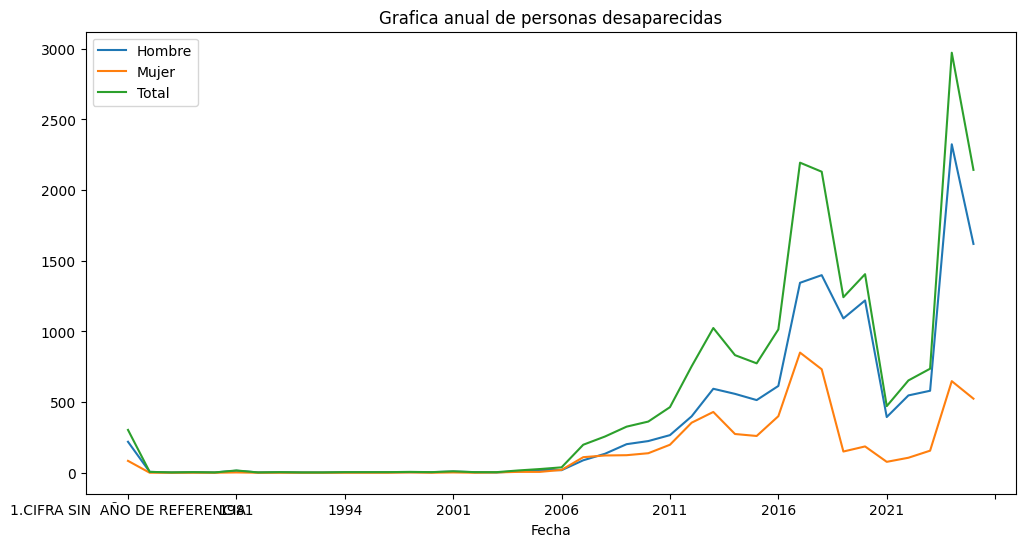

In [57]:
# Agrupacion por anio, es relavante ya que nos puede indicar como evoluciona la lista de desaparecodos
resumen_anio = df_total_municipio.groupby(df_total_municipio.index)[['Hombre', 'Mujer']].sum()
resumen_anio['Total'] = resumen_anio.sum(axis=1)
resumen_anio.plot(kind='line', y=['Hombre','Mujer','Total'], figsize=(12,6), title="Grafica anual de personas desaparecidas")


## Practicando a ser investigador de APIs

Ahora te pido que revises si puedes encontrar otros endpoints para recuperar mas información de las bases que no se encuentran liberadas. Puede ser en la misma página, o en blogs o revisando código. Agrega en esta libreta la documentación (o enlaces a dicha documentación) y un ejemplo de uso de una API pobremente documentada.

revisando el ccodigo de la paginia unicamente se encontraron los endpoints
Fechas	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.2 kB	667 ms
Totales	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.5 kB	26.60 s
Bitacora	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.1 kB	76 ms
PieChartDesaparecidos	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.4 kB	24.44 s
PieChartLocalizados	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.4 kB	28.13 s
PieChartNacionalidad	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.5 kB	810 ms
PieChartDesaparecidosEstado	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	5.4 kB	26.91 s
PieChartSexoEstatus	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.4 kB	22.18 s
PieChartSexoEstatus	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.4 kB	21.26 s
PieChartSexoEstatus	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.4 kB	13.28 s
MapChartEntidades	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	0.7 kB	22.79 s
BarChartFoliosIniciadosActualizadosFiscalias	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.9 kB	19.41 s
BarChartFoliosIniciadosPortal	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.3 kB	23.20 s
BarChartFoliosIniciadosActualizadosComisiones	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.8 kB	9.27 s
BarChartSexoEstados	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.5 kB	12.35 s
AreaChartSexoAnio	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.8 kB	10.81 s
AreaChartSexoRango	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.1 kB	3.33 s
BarChartSexoNacionalidad	200	xhr	jquery?v=9ktsOtIo0upvJP7-7FiXuOoOJe58RLFJ__wIRPL2vGo1:1	1.3 kB	2.10 s
collect?v=2&tid=G-1HYVDHWC9H&gtm=45je59h0v91895734…%20CNB&en=scroll&epn.percent_scrolled=90&tfd=5655	204	fetch	js?id=G-1HYVDHWC9H:210	0.0 kB	206 ms

In [63]:

API_HOST = "https://versionpublicarnpdno.segob.gob.mx/"
ENDPOINT = "Sociodemografico/BarChartSexoEstados"

session = requests.Session()
session.get("https://versionpublicarnpdno.segob.gob.mx/Dashboard/Index")
session.get("https://versionpublicarnpdno.segob.gob.mx/Dashboard/ContextoGeneral")

# Datos de la consulta
DATA = {
    "idEstado": "0",       # 0 = Todos los estados
    "idMunicipio": "0",
    "idColonia": "0",
    "idEstatusVictima": "0",
    "idHipotesisNoLocalizacion": "0",
    "idDelito": "0",
}

r = session.post(API_HOST + ENDPOINT, json=DATA)

# Verificar que la respuesta sea JSO balido
try:
    res = r.json()
except requests.JSONDecodeError:
    print("No es JSON válido:", r.text)
    res = None
if res:
    datos = {serie['name']: serie['data'] for serie in res['Series']}
    datos['Estado'] = res['XAxisCategories']

    df = pd.DataFrame(datos)
    df.set_index('Estado', inplace=True)

df.head()


,Hombre,Mujer,Indeterminado
Estado,,,
AGUASCALIENTES,3287,3614,2
BAJA CALIFORNIA,5170,2848,8
BAJA CALIFORNIA SUR,2133,1106,3
CAMPECHE,844,1035,1
COAHUILA,3828,1375,11
